# Tree models

In [1]:
import os
import sys

import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from joblib import load

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

In [4]:
path_tuning = "./results_tuning"

## Random Forest

### Basic Random Forest

In [4]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(date_encoder, add_date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [5]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [6]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.28
Test set, RMSE=0.45


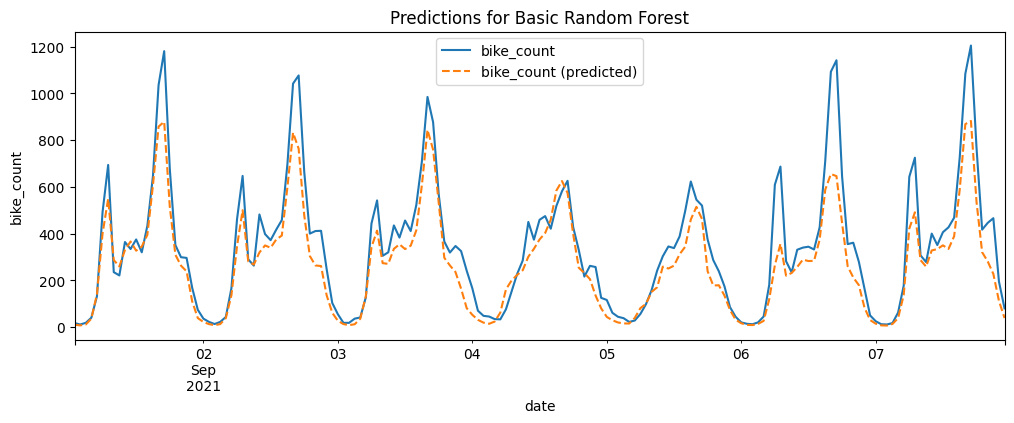

In [7]:
problem.week_plot(X_test, y_pred_test, y_test, "Basic Random Forest")

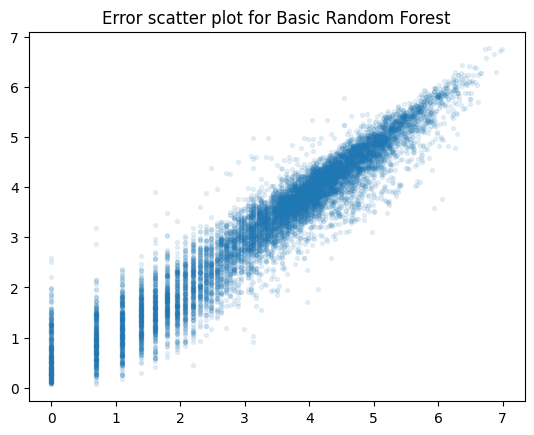

In [8]:
problem.error_plot(y_pred_test, y_test, "Basic Random Forest")

### Random Forest with additional date variables

In [9]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(problem._additional_date_variables)
add_date_cols = ["season"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["counter_name", "site_name"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("cat", categorical_encoder, categorical_cols),
    ],
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(date_encoder, add_date_encoder, preprocessor, regressor)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 11.2min finished


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>)),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _drop_cols at 0x7f8b319b8ee0>,
                                     kw_args={'cols': ['coun...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name',
                                                   'site_name'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5,
                                       n_jobs=4, verbose=1))])

In [10]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [11]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.28
Test set, RMSE=0.45


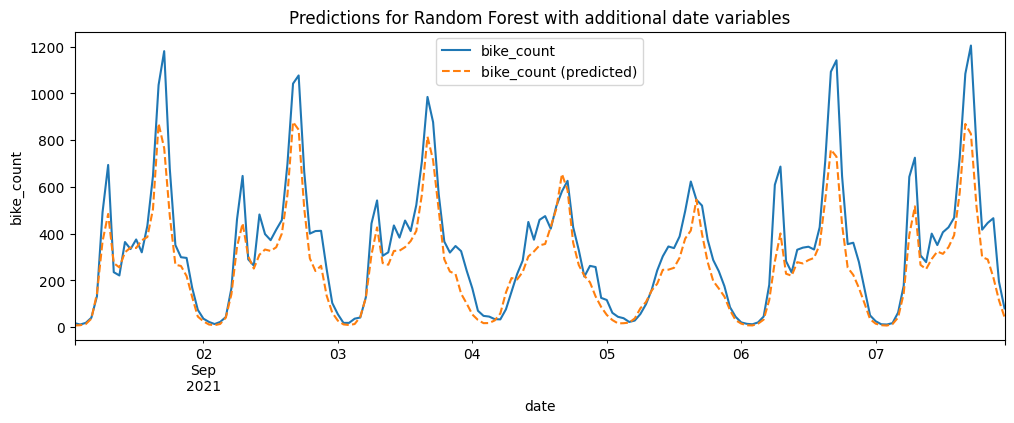

In [12]:
problem.week_plot(
    X_test, y_pred_test, y_test, "Random Forest with additional date variables"
)

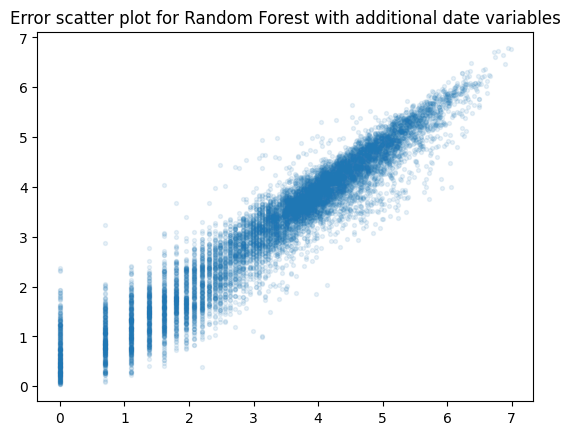

In [13]:
problem.error_plot(y_pred_test, y_test, "Random Forest with additional date variables")

### Random Forest with additional date variables and weather data

In [14]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]
categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = RandomForestRegressor(
    max_features="sqrt", verbose=1, n_jobs=4, max_samples=0.5
)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  6.9min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed: 16.0min finished


Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f8b319b8e50>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f8b319b89d0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f8b319b8dc0>,
                                     kw_args={'dr...
                                   transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('add_date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['season']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_features='sqrt', max_samples=0.5,
                                       n_jobs=4, verbose=1))])

In [15]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [16]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.29
Test set, RMSE=0.56


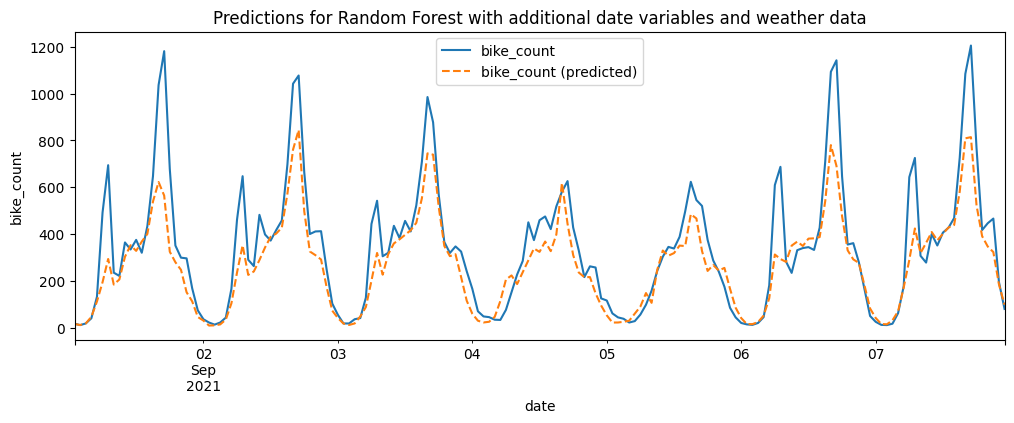

In [17]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Random Forest with additional date variables and weather data",
)

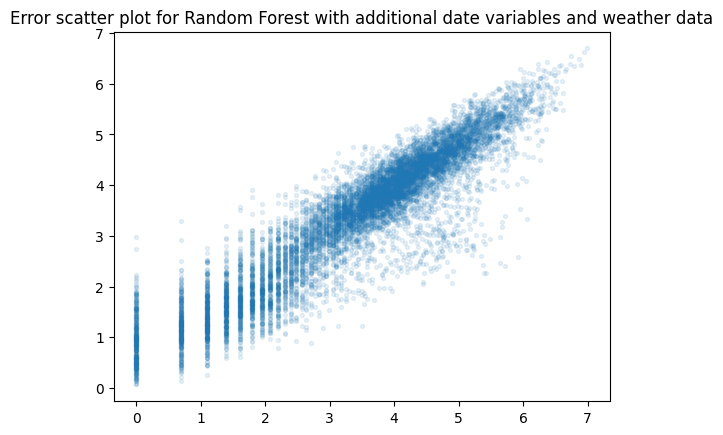

In [18]:
problem.error_plot(
    y_pred_test, y_test, "Random Forest with additional date variables and weather data"
)

In [19]:
# get the depths to have a feeling for tuning
depths = [i.get_depth() for i in pipe["randomforestregressor"].estimators_]
print(min(depths))
print(max(depths))

68
93


### Tuned Random Forest with additional date variables and weather data

First used grid: 

```
# define grid for parameter tuning
    grid = {
        "randomforestregressor__n_estimators": [200, 400],
        "randomforestregressor__max_samples": [0.4, 0.6, 0.8],
        "randomforestregressor__max_depth": [20, 40, 60, 80],
        "randomforestregressor__max_features": ["sqrt", 0.2],
    }
```

After checking the first results in the terminal (since we use the verbose parameter for GridSearchCV), we decided to adjust the grid to the following to limit runtime and finetune a bit more.

```
grid = {
        "randomforestregressor__n_estimators": [300],
        "randomforestregressor__max_samples": [0.4, 0.5, 0.6],
        "randomforestregressor__max_depth": [30, 40],
        "randomforestregressor__max_features": ["sqrt", 0.15, 0.25],
    }
```

In [6]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221118_2031_tuning_RF_cv_results.csv")
)
tuning_rf = load(
    os.path.join(path_tuning, "20221118_2031_tuning_RF_best_estimator.pkl")
)

/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator FunctionTransformer from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator OneHotEncoder from version 1.1.3 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mariastoelben/opt/anaconda3/envs/bikes-ramp/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from 

In [49]:
y_pred_train = tuning_rf.predict(X_train)
y_pred_test = tuning_rf.predict(X_test)

In [50]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.34
Test set, RMSE=0.51


In [66]:
cv_results[cv_results.rank_test_score == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__max_features,param_randomforestregressor__max_samples,param_randomforestregressor__n_estimators,params,split0_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
17,5080.091991,3521.156278,1.882334,0.424236,40,0.25,0.6,300,"{'randomforestregressor__max_depth': 40, 'rand...",-0.93389,...,-0.268846,-0.282976,-0.297099,-0.312871,-0.316521,-0.331221,-0.334895,-0.33616,-0.310074,0.02344


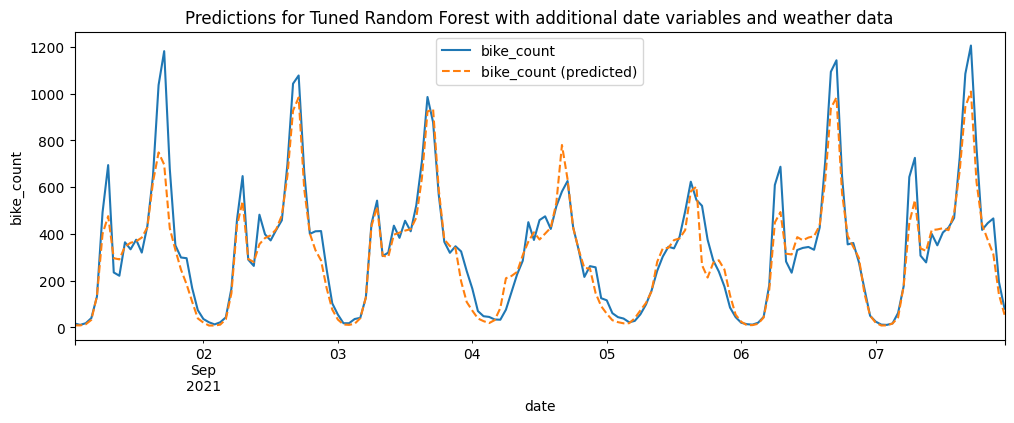

In [51]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned Random Forest with additional date variables and weather data",
)

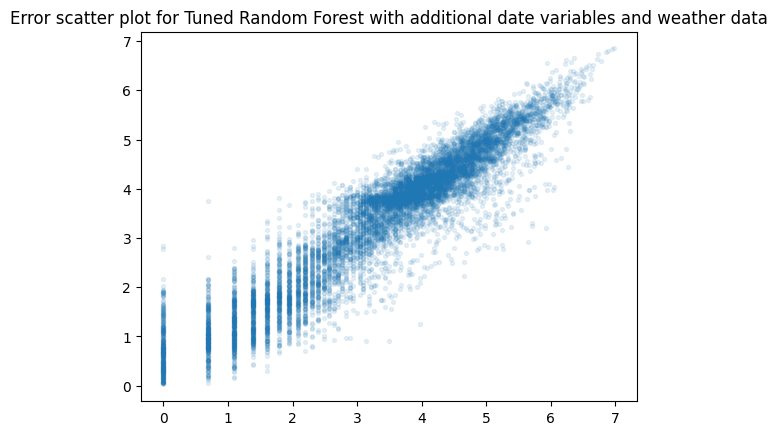

In [52]:
problem.error_plot(
    y_pred_test,
    y_test,
    "Tuned Random Forest with additional date variables and weather data",
)

## XGB


### XGB with additional date variables and weather data

In [38]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        ("date", OneHotEncoder(handle_unknown="ignore"), date_cols + add_date_cols),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ],
)

regressor = XGBRegressor()

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7fb2e8449ee0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7fb2e8449a60>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7fb2e8449e50>,
                                     kw_args={'dr...
                              feature_types=None, gamma=0, gpu_id=-1,
                              grow_policy='depthwise', importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_bin=256,
                              max_cat_threshold=64, max_cat_to_onehot=4,
                              max_delta_step=0, max_depth=6, max_leaves=0,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=0, num_parallel_tree=1, predictor='auto',
                              random_state=0, ...))])

In [43]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

In [44]:
print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.40
Test set, RMSE=0.49


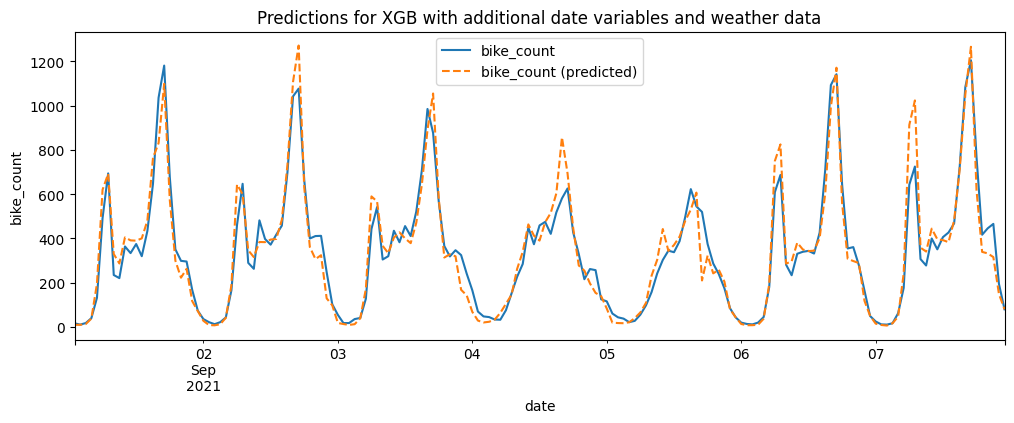

In [45]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "XGB with additional date variables and weather data",
)

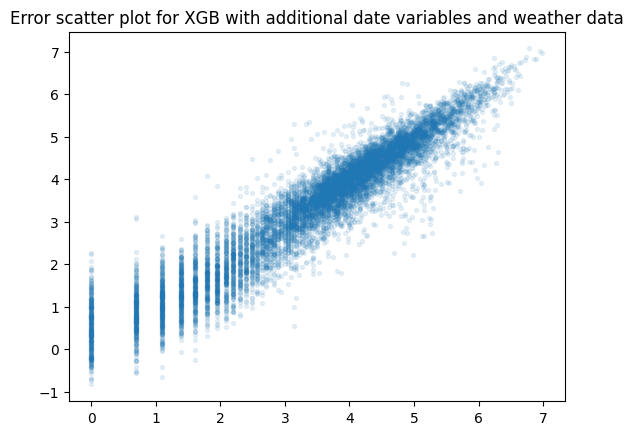

In [46]:
problem.error_plot(
    y_pred_test, y_test, "XGB with additional date variables and weather data"
)

### Tuned XGB with external data

After a first run we redefined the grid to tune on a more granular level (see following grid):
```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__colsample_bytree": [.7, .8],
        "xgbregressor__colsample_bylevel": [.7, .8],
        "xgbregressor__colsample_bynode": [.7, .8, 1.],
        "xgbregressor__max_depth": [7, 8, 9, 10],
        "xgbregressor__subsample": [.7, .8, .9],
    }
```
```
grid = {
        "xgbregressor__n_estimators": [400],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__colsample_bytree": [.5, .6, .7],
        "xgbregressor__colsample_bylevel": [.5, .6, .7],
        "xgbregressor__colsample_bynode": [.5, .6, .7],
        "xgbregressor__max_depth": [9, 10],
        "xgbregressor__subsample": [.8],
    }
```

In [70]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_1816_tuning_xgb_cv_results.csv")
)
tuning_xgb = load(
    os.path.join(path_tuning, "20221119_1816_tuning_xgb_best_estimator.pkl")
)

In [101]:
cv_results.sort_values(by="rank_test_score").iloc[:5, 12:]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,...,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,mean_train_score,std_train_score
10,-0.903910,-0.741776,-0.744068,-0.603418,-0.677565,-0.733543,-0.869889,-0.723329,-0.749687,0.090746,...,-0.216569,-0.272860,-0.299782,-0.318488,-0.332075,-0.340909,-0.351789,-0.356327,-0.311100,0.044174
34,-0.886906,-0.716760,-0.737092,-0.609239,-0.672979,-0.771326,-0.887652,-0.727472,-0.751178,0.090595,...,-0.213832,-0.270443,-0.298693,-0.317756,-0.327040,-0.338538,-0.350268,-0.352150,-0.308590,0.044000
83,-0.890661,-0.745642,-0.741817,-0.597179,-0.677278,-0.754003,-0.882583,-0.725753,-0.751864,0.091288,...,-0.212427,-0.270860,-0.297121,-0.318657,-0.329288,-0.339763,-0.351421,-0.351004,-0.308818,0.044633
17,-0.882751,-0.757485,-0.748090,-0.605579,-0.678802,-0.749863,-0.857207,-0.735219,-0.751875,0.083136,...,-0.273440,-0.328842,-0.354608,-0.376246,-0.389528,-0.402461,-0.410327,-0.415090,-0.368818,0.045245
6,-0.879042,-0.732316,-0.736158,-0.600863,-0.679763,-0.756585,-0.907872,-0.725046,-0.752206,0.093463,...,-0.249576,-0.305828,-0.327965,-0.349266,-0.359079,-0.373099,-0.382460,-0.386396,-0.341709,0.043253


In [72]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.36
Test set, RMSE=0.47


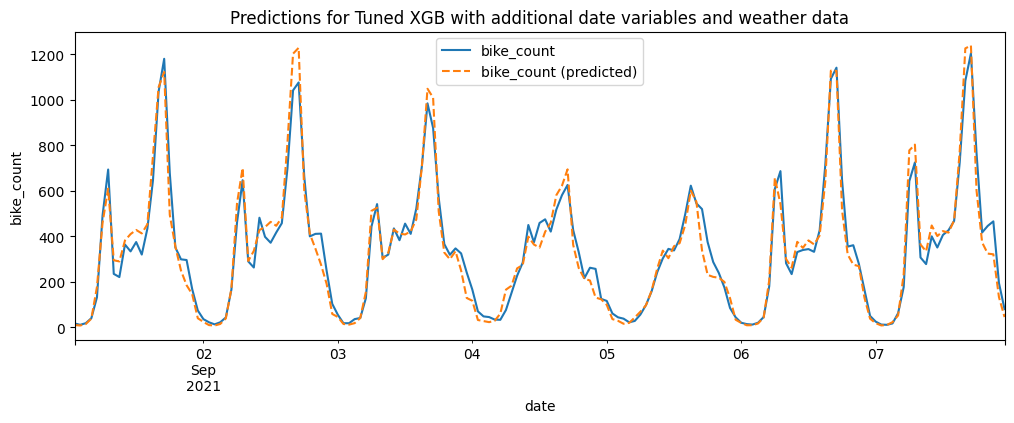

In [73]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "Tuned XGB with additional date variables and weather data",
)

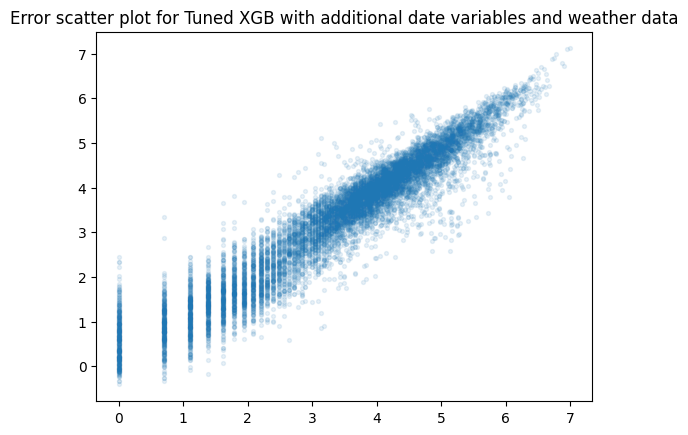

In [74]:
problem.error_plot(
    y_pred_test, y_test, "Tuned XGB with additional date variables and weather data"
)

In [5]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221120_1508_tuning_xgb_cv_results.csv")
)
tuning_xgb = load(
    os.path.join(path_tuning, "20221120_1508_tuning_xgb_best_estimator.pkl")
)

In [17]:
cv_results.sort_values(by="rank_test_score").iloc[:5, :22]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__colsample_bylevel,param_xgbregressor__colsample_bynode,param_xgbregressor__colsample_bytree,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__n_estimators,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score
9,115.184453,36.849198,0.370370,0.071452,0.5,0.6,0.6,0.1,10,400,...,-0.896049,-0.741485,-0.730245,-0.610350,-0.673084,-0.753055,-0.831505,-0.723836,-0.744951,0.082420
35,454.974226,190.883996,0.463552,0.088217,0.6,0.7,0.7,0.1,10,400,...,-0.899664,-0.745357,-0.734357,-0.597777,-0.678982,-0.717297,-0.875434,-0.715735,-0.745575,0.092670
23,161.923125,30.624491,0.396698,0.084455,0.6,0.5,0.7,0.1,10,400,...,-0.883820,-0.735901,-0.737757,-0.597646,-0.671598,-0.744394,-0.870559,-0.730180,-0.746482,0.088371
7,98.377589,33.808409,0.376299,0.080771,0.5,0.6,0.5,0.1,10,400,...,-0.907761,-0.731056,-0.729765,-0.608732,-0.674194,-0.737507,-0.898365,-0.695835,-0.747902,0.097741
16,97.723915,32.626238,0.359655,0.059627,0.5,0.7,0.7,0.1,9,400,...,-0.896812,-0.721260,-0.736681,-0.589642,-0.672593,-0.746092,-0.875900,-0.745072,-0.748006,0.093623


In [12]:
y_pred_train = tuning_xgb.predict(X_train)
y_pred_test = tuning_xgb.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.35
Test set, RMSE=0.46


#### Tuning with dart
```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [.1],

        "xgbregressor__booster": ["dart"],
        "xgbregressor__rate_drop": [.0, .05, .1],
        "xgbregressor__rate_drop": [0, 1],
        "xgbregressor__skip_drop": [.0, .05, .1],

        "xgbregressor__colsample_bytree": [.7, .8],
        "xgbregressor__colsample_bylevel": [.7, .8],
        "xgbregressor__colsample_bynode": [.7, .8],
        "xgbregressor__max_depth": [8, 10],
        "xgbregressor__subsample": [.7, .8],
    }
```

In [8]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221119_2340_tuning_xgb_cv_results.csv")
)
tuning_xgb = load(
    os.path.join(path_tuning, "20221119_2340_tuning_xgb_best_estimator.pkl")
)

In [12]:
cv_results.sort_values(by="rank_test_score").iloc[:5, 14:24]

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score
39,-0.898488,-0.742151,-0.756816,-0.625408,-0.689965,-0.784618,-0.877542,-0.731217,-0.763276,0.084921
94,-0.904140,-0.740288,-0.767003,-0.612917,-0.693286,-0.764068,-0.886484,-0.745949,-0.764267,0.088998
199,-0.894215,-0.758524,-0.764720,-0.605993,-0.677040,-0.758083,-0.921021,-0.750821,-0.766302,0.096395
40,-0.898742,-0.741847,-0.764530,-0.643723,-0.687397,-0.773586,-0.863016,-0.762644,-0.766936,0.078111
148,-0.915895,-0.759398,-0.733648,-0.642604,-0.682436,-0.765630,-0.901089,-0.750612,-0.768914,0.089573


```
grid = {
        "xgbregressor__n_estimators": [300],
        "xgbregressor__learning_rate": [0.1],
        "xgbregressor__colsample_bytree": [.6, .7, .8],
        "xgbregressor__colsample_bylevel": [.5, .6],
        "xgbregressor__colsample_bynode": [.6, .8],
        "xgbregressor__max_depth": [4, 6, 8, 10],
        "xgbregressor__subsample": [.6, .7, .8, .9, 1],
        "xgbregressor__min_child_weight": [1, 10],
    }
```

In [5]:
cv_results = pd.read_csv(
    os.path.join(path_tuning, "20221122_1844_tuning_xgb_reduced_lower_cv_results.csv")
)
tuning_xgb = load(
    os.path.join(path_tuning, "20221122_1844_tuning_xgb_reduced_lower_best_estimator.pkl")
)

In [15]:
cv_results.sort_values(by="rank_test_score").iloc[:10, :23]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbregressor__colsample_bylevel,param_xgbregressor__colsample_bynode,param_xgbregressor__colsample_bytree,param_xgbregressor__learning_rate,param_xgbregressor__max_depth,param_xgbregressor__min_child_weight,...,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score
311,16.070049,3.197837,0.469527,0.045154,0.6,0.6,0.7,0.1,10,1,...,-0.874731,-0.722461,-0.757252,-0.594986,-0.664142,-0.749787,-0.842791,-0.693879,-0.737503,0.085352
151,18.867709,4.843459,0.572814,0.198878,0.5,0.8,0.6,0.1,10,1,...,-0.871970,-0.736785,-0.760586,-0.592409,-0.672475,-0.750502,-0.822446,-0.713236,-0.740051,0.080481
271,15.671717,3.953223,0.470604,0.082268,0.6,0.6,0.6,0.1,10,1,...,-0.888786,-0.718155,-0.765787,-0.588462,-0.674153,-0.742138,-0.859261,-0.683862,-0.740076,0.092167
315,13.789709,3.802716,0.458634,0.057387,0.6,0.6,0.7,0.1,10,10,...,-0.881247,-0.708143,-0.773343,-0.583294,-0.667659,-0.743525,-0.866779,-0.713003,-0.742124,0.092632
194,17.738198,3.240103,0.528321,0.103168,0.5,0.8,0.7,0.1,10,1,...,-0.884716,-0.727096,-0.752760,-0.574977,-0.664420,-0.760222,-0.859236,-0.714109,-0.742192,0.093190
356,14.825418,3.730366,0.492319,0.053995,0.6,0.6,0.8,0.1,10,10,...,-0.884051,-0.721588,-0.768977,-0.578604,-0.673043,-0.733420,-0.860816,-0.721183,-0.742710,0.091785
76,15.065017,2.979279,0.470365,0.047506,0.5,0.6,0.7,0.1,10,10,...,-0.883349,-0.712226,-0.773760,-0.578148,-0.669534,-0.752554,-0.860353,-0.713530,-0.742932,0.092801
277,14.588003,4.893132,0.486545,0.101222,0.6,0.6,0.6,0.1,10,10,...,-0.873026,-0.711416,-0.756456,-0.618525,-0.675192,-0.757052,-0.848153,-0.705073,-0.743112,0.079742
141,11.839970,2.703344,0.384561,0.050901,0.5,0.8,0.6,0.1,8,1,...,-0.868310,-0.709177,-0.756834,-0.613066,-0.678342,-0.759968,-0.884900,-0.681047,-0.743956,0.088286
390,15.873635,4.016407,0.523811,0.099081,0.6,0.8,0.6,0.1,10,1,...,-0.906123,-0.726837,-0.750783,-0.597472,-0.673086,-0.753168,-0.830306,-0.713999,-0.743972,0.087719


## Histogram-based GB

In [40]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        (
            "date",
            OneHotEncoder(handle_unknown="ignore", sparse=False),
            date_cols + add_date_cols,
        ),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
    ],
)

regressor = HistGradientBoostingRegressor(max_iter=1000)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7fcb1177db80>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7fcb1177da60>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7fcb1177daf0>,
                                     kw_args={'dr...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour',
                                                   'season']),
                                                 ('num', StandardScaler(),
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('histgradientboostingregressor',
                 HistGradientBoostingRegressor(max_iter=1000))])

In [41]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.39
Test set, RMSE=0.47


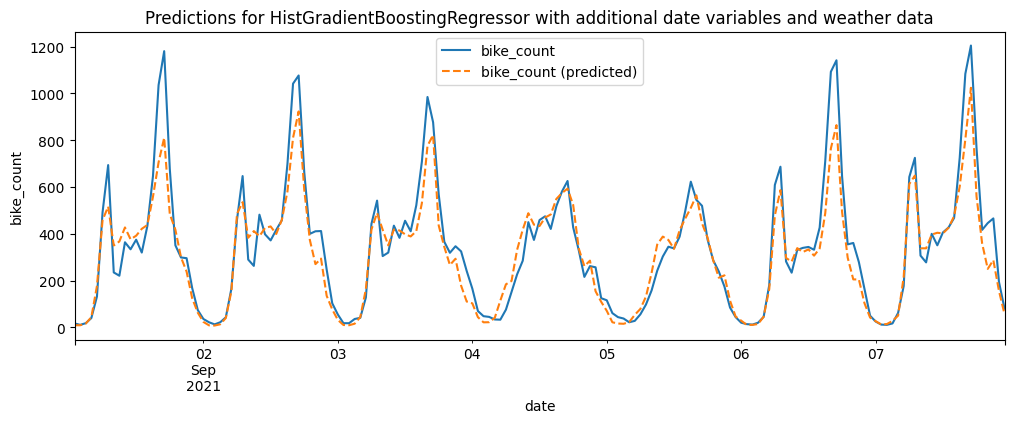

In [42]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "HistGradientBoostingRegressor with additional date variables and weather data",
)

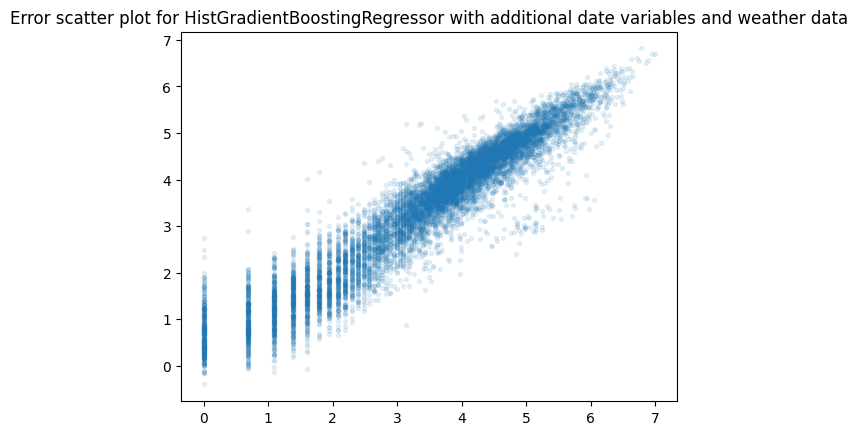

In [43]:
problem.error_plot(
    y_pred_test,
    y_test,
    "HistGradientBoostingRegressor with additional date variables and weather data",
)